* 구글 Colab을 이용하는 경우

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/2023.03.20_AI미니프로젝트3차/Datasets

/content/drive/MyDrive/2023.03.20_AI미니프로젝트3차/Datasets


### (1) Data Augmentation
- **세부요구사항**
    * 모델 학습에 이용할 이미지 데이터를 증강시키세요.
    * Keras의 ImageDataGenerator를 이용
        - [ImageDataGenerator document](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

    * image generator를 이용하여 학습
        * 모델 구조는 이미 생성한 1,2,3 중 하나를 선택하여 학습


In [3]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
img_size = 280 ## 사이즈 조정 가능
seed = 2023

train_path = 'traindata/data/'
test_path = 'testdata/'

#### 1) ImageGenerator 생성
* ImageDataGenerator 함수 사용
    * 주요 옵션
        * rotation_range: 무작위 회전을 적용할 각도 범위
        * zoom_range: 무작위 줌을 적용할 범위 [1-zoom_range, 1+zoom_range]
        * horizontal_flip: 무작위 좌우반전을 적용할지 여부
        * vertical_flip: 무작위 상하반전을 적용할지 여부
        * rescale: 텐서의 모든 값을 rescale 값으로 나누어줌 (이 경우에는 255로 나누어서 0~1사이의 값으로 변경)

In [13]:
import glob, os
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
import cv2

In [70]:
def glos(folder):
    print(folder)
    files = glob.glob(folder+'*')
    data, label = zip(*[[img_to_array(cv2.resize( cv2.cvtColor(cv2.imread(f),cv2.COLOR_BGR2RGB),dsize=(280, 280),)), 1 if os.path.split(f)[1][:2] == 'ab' else 0 ] for f in files])
    return np.array(list(data)), np.array(list(label))

In [71]:
train_data, train_label = glos(train_path)
#test_data, test_label = glos(test_path)

traindata/data/


In [72]:
print(train_data.shape, train_label.shape)
#print(test_data.shape, test_label.shape)

(2309, 280, 280, 3) (2309,)


In [9]:
# data augmentation Cutmix

In [73]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

#x_min, y_min, x_max, y_max = get_clip_box(train_data[1], train_data[0])

#print('x : ', x_min, x_max)
#print('y : ', y_min, y_max)

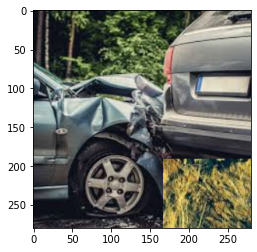

In [74]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(train_data[1], train_data[0], x_min, y_min, x_max, y_max)
#plt.imshow(mixed_img.numpy())
plt.imshow((mixed_img.numpy()).astype(np.uint8))
plt.show()

In [75]:
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=2):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

#mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
#mixed_label

In [76]:
def cutmix(image, label, prob=1.0, batch_size=300, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [84]:
batch_size = 300
mixed_imgs, mixed_labels = cutmix(train_data, train_label, batch_size = batch_size, img_size=280, num_classes=2)

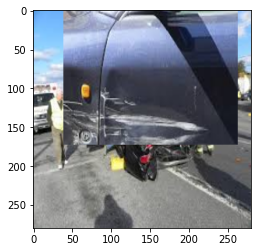

In [80]:
plt.imshow((mixed_imgs[5].numpy()).astype(np.uint8))

In [85]:
mixed_imgs.shape

TensorShape([300, 280, 280, 3])

In [98]:
%cd mixedData

/content/drive/MyDrive/2023.03.20_AI미니프로젝트3차/Datasets/mixedData


In [99]:
ls

In [100]:
for num,image in enumerate(mixed_imgs):
    temp = Image.fromarray((image.numpy()).astype(np.uint8))
    temp.save(f'ab_{num}.jpg')